In [1]:
import jax
import jax.numpy as jnp
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from jax import random
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from heidelberg_v01 import plot_error, plot_spikes, plot_traces, run, run_example, load_data, load_datasets
from spikegd.theta import ThetaNeuron
from spikegd.utils.plotting import (
    cm2inch,
    panel_label,
)

In [2]:
plt.style.use("spikegd.utils.plotstyle")

In [3]:
jax.devices()

[CudaDevice(id=0)]

In [4]:
datasets = load_datasets("data", verbose=True)

Loading data from h5 file
Loading audio filenames
Finished loading SHD
Loading data from h5 file
Loading audio filenames
Finished loading SHD


# Run experiments

In [14]:
config_theta = {
    "seed": 0,
    # Neuron
    "tau": 6 / jnp.pi,
    "I0": 5 / 4,
    "eps": 1e-6,
    # Network
    # "Nin": 7000, # must be N * Nt, where N is the number of neurons in the SHD dataset (700)
    "Nin_virtual": 12,  # #Virtual input neurons = N_bin - 1
    "Nhidden": 80,
    "Nlayer": 2,  # Number of layers
    "Nout": 20,
    "w_scale": 0.5,  # Scaling factor of initial weights
    # Trial
    "T": 2.0,
    "K": 150,  # Maximal number of simulated ordinary spikes
    "dt": 0.001,  # Step size used to compute state traces
    # Training
    "gamma": 1e-2,
    "Nbatch": 1000,
    "lr": 4e-3,
    "tau_lr": 1e2,
    "beta1": 0.9,
    "beta2": 0.999,
    "p_flip": 0.0,
    "Nepochs": 200,
    "Ntrain": None, # Number of training samples

    # SHD Quantization
    "Nt": 8,

    "verbose": True,
}
Nin_data = 700
config_theta["Nin"] = Nin_data * config_theta["Nt"]


def run_theta(config: dict, data_loaders=None):
    """
    Wrapper to train a network of Theta neurons with the given configuration.

    See docstring of `run` and article for more information.
    """
    if data_loaders is None:
        data_loaders = load_data(datasets, config)

    tau, I0, eps = config["tau"], config["I0"], config["eps"]
    neuron = ThetaNeuron(tau, I0, eps)
    metrics, perf_metrics = run(neuron, data_loaders, config, progress_bar="notebook")
    return metrics, perf_metrics

In [15]:
def run_theta_ensemble(config: dict, samples: int = 1, data_loaders=None) -> dict:
    seed = 0
    key = random.PRNGKey(seed)
    seeds = random.randint(key, (samples,), 0, jnp.uint32(2**32 - 1), dtype=jnp.uint32)
    metrics_list = []

    # load data once if not provided
    if data_loaders is None:
        data_loaders = load_data(datasets, config)

    for seed in seeds:
        config_theta = {**config, "seed": seed}
        metrics, perf_metrics = run_theta(config_theta, data_loaders)
        metrics_list.append(metrics | perf_metrics)
    metrics = jax.tree.map(lambda *args: jnp.stack(args), *metrics_list)
    
    return metrics

metrics = run_theta_ensemble(config_theta, 3)
metrics_example = { key: value[0] for key, value in metrics.items() }

Max spike count in single time interval (23) is very different to N_bin (13)
Max spike count in single time interval (21) is very different to N_bin (13)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [16]:
def get_summary_metrics(metrics: dict, epoch: int = -1) -> dict:
    summary_metrics = {}

    for key, value in metrics.items():
        if key.startswith("perf."):
            # Not epoch-specific
            summary_metrics[key] = value
        elif key not in ["p_init", "p_end"]:
            # Epoch-specific
            summary_metrics[key] = value[:, epoch]

    return summary_metrics

def summarize_metrics(metrics: dict, epoch: int) -> None:
    """
    Print a summary of the metrics at the given epoch.
    """
    summary_metrics = get_summary_metrics(metrics, epoch)

    summary_metrics = jax.tree.map(
        lambda x: jnp.array([jnp.mean(x), jnp.std(x)]),
        summary_metrics,
    )
    for key, value in summary_metrics.items():
        print(f"{key:<25} {value[0]:.3f} ± {value[1]:.3f}")


print("**Results before training**")
summarize_metrics(metrics, 0)
print()
print("**Results after training**")
summarize_metrics(metrics, -1)

**Results before training**
acc                       0.052 ± 0.003
acc_ord                   0.045 ± 0.002
activity                  0.000 ± 0.000
activity_first            0.000 ± 0.000
loss                      3.040 ± 0.004
loss_ord                  3.013 ± 0.000
perf.compilation_time     0.001 ± 0.000
perf.optim_init_time      0.003 ± 0.001
perf.phi0_init_time       0.001 ± 0.000
perf.weights_init_time    0.001 ± 0.000
silent_neurons            0.971 ± 0.016
silent_neurons_first      0.971 ± 0.016

**Results after training**
acc                       0.816 ± 0.019
acc_ord                   0.699 ± 0.068
activity                  0.258 ± 0.051
activity_first            0.244 ± 0.044
loss                      0.941 ± 0.122
loss_ord                  2.684 ± 0.137
perf.compilation_time     0.001 ± 0.000
perf.optim_init_time      0.003 ± 0.001
perf.phi0_init_time       0.001 ± 0.000
perf.weights_init_time    0.001 ± 0.000
silent_neurons            0.363 ± 0.020
silent_neurons_first    

In [19]:
acc_mean_arr = metrics["acc"].mean(axis=0)
acc_std_arr = metrics["acc"].std(axis=0)

best_epoch = jnp.argmax(acc_mean_arr)
best_acc_mean = acc_mean_arr[best_epoch]
best_acc_std = acc_std_arr[best_epoch]
print(f"Best accuracy in epoch {best_epoch}:  {best_acc_mean:.3f} ± {best_acc_std:.3f}")

Best accuracy in epoch 19:  0.846 ± 0.002


# Test error over time

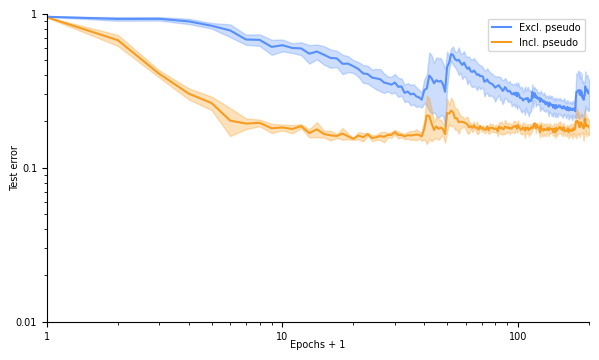

In [20]:
fig, ax = plt.subplots(figsize=(7, 4))
plot_error(ax, metrics, config_theta)

In [9]:

def run_example_theta(p: list, config: dict) -> dict:
    """
    Wrapper to run network on one example input.

    See docstring of `run_example` and article for more information.
    """
    tau, I0, eps = config["tau"], config["I0"], config["eps"]
    neuron = ThetaNeuron(tau, I0, eps)
    metrics = run_example(p, neuron, config)
    return metrics


example_init = run_example_theta(metrics_example["p_init"], config_theta)
example_end = run_example_theta(metrics_example["p_end"], config_theta)

TypeError: run_example() missing 1 required positional argument: 'config'

# Plot results

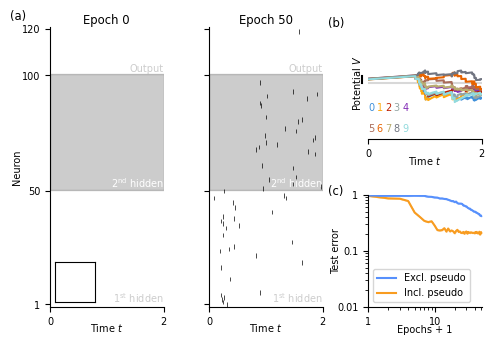

In [ ]:
### Figure
fig = plt.figure(figsize=cm2inch(1.5 * 8.6, 1.5 * 6.0))
gs = gridspec.GridSpec(
    2,
    3,
    figure=fig,
    hspace=0.5,
    wspace=0.4,
    top=0.94,
    bottom=0.15,
    left=0.12,
    right=0.97,
)

#### Spike plot before learning
ax = fig.add_subplot(gs[:, 0])
plot_spikes(ax, example_init, config_theta)
ax.set_title("Epoch 0", pad=-1)
axins = inset_axes(ax, width=0.4, height=0.4, loc="lower left")
# axins.imshow(example_init["input"].reshape(28, 28), cmap="gray")
axins.set_xticks([])
axins.set_yticks([])
axins.spines["top"].set_visible(True)
axins.spines["right"].set_visible(True)
panel_label(fig, ax, "(a)", x=-0.4, y=0.07)

#### Spike plot after learning
ax = fig.add_subplot(gs[:, 1])
plot_spikes(ax, example_end, config_theta)
ax.set_title(f"Epoch {config_theta['Nepochs']}", pad=-1)
ax.tick_params(labelleft=False)
ax.set_ylabel("")

### Trace output
ax = fig.add_subplot(gs[0, 2])
plot_traces(ax, example_end, config_theta)
panel_label(fig, ax, "(b)", x=-0.4, y=0.0)

### Accuracy plot
ax = fig.add_subplot(gs[1, 2])
plot_error(ax, metrics, config_theta)
panel_label(fig, ax, "(c)", x=-0.4, y=0.0)

plt.show()